# State vs. Response Stratification Bar Chart

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 6

In [1]:
#######################################################################################
#                                                                                     #
#            Plot multi-panel boxplot figure showing how both ESA state               #
#            and response functions can stratify by PBL scheme. Meant                 #
#               specifically for figure in Faletti et al. (2024).                     #
#                                                                                     #
#######################################################################################

# Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr

from scipy import stats

# Import authored modules
import centered_response as cr
from wofunits import wofunits

# To selectively suppress warnings
import logging

# Define common directories for file paths
sensdir = wofunits.paths['sens_path'] # sensitivity data path
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
wofsdir_3d = wofunits.paths['wofs_path_3d'] # 3D WoFS data path
outplot_path = wofunits.paths['outplot_path'] # plot save path

In [2]:
################################ Set case/plotting specs  #######################################

    # save scatter plots?
save = True

    # select case
case = '201905172100'
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
#case = '201905282230'

    # sensitivity specs
varlist = ['T2','TD2','SHEAR_TOT1'] # state variables to plot
respvar = 'UH-HRSWT25-WRF' # response variable
state_time = datetime.datetime(2019,5,17,22,30) # valid state time to plot

    # plotting specs
axlabels = ['a)','b)','c)','d)'] # axis labels
colors = ['tab:orange', 'tab:blue', 'tab:green', 'gray'] # bar colors

In [3]:
######################## Automated definition of variables  ###############################

    # pull case specs
wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

#resptime_dt = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')

    # sets ground-relative response variable
if 'HRSWT' in respvar:
    respvar_filestr = 'UH_HRSWT25_WRF'
if '30SWT' in respvar:
    respvar_filestr = 'UH_30SWT25_WRF'

#respfile = f'{sensdir}/sens_{case}/resp_{respvar_filestr}_max_{resptime}.nc'    
#statefile = f''
    # define PBL scheme indices
ysu_idx, myj_idx, mynn_idx = wofunits.schemeidx['ysu'], wofunits.schemeidx['myj'], wofunits.schemeidx['mynn']

In [4]:
means=[]
for var in varlist:
    
    statevar_str = var.replace('_','-')
    
    file_state_gr = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
    file_resp_gr = f'{sensdir}/sens_{case}/resp_{respvar_filestr}_max_{resptime}.nc'
    file_sens_gr = f'{sensdir}/sens_{case}/stats_{respvar}_max_{resptime[11:]}_{statevar_str}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    
    ds_state_gr = xr.open_dataset(file_state_gr)
    ds_resp_gr = xr.open_dataset(file_resp_gr)
    ds_sens_gr = xr.open_dataset(file_sens_gr)
    
        # define lat/lon
    lat = ds_state_gr.XLAT[0]
    lon = ds_state_gr.XLONG[0]
    
        # define response box lims
    xlimleft = ds_resp_gr.RF_CENTER_LON + ds_resp_gr.RF_X_LEFT
    xlimright = ds_resp_gr.RF_CENTER_LON + ds_resp_gr.RF_X_RIGHT
    ylimbot = ds_resp_gr.RF_CENTER_LAT + ds_resp_gr.RF_Y_BOTTOM
    ylimtop = ds_resp_gr.RF_CENTER_LAT + ds_resp_gr.RF_Y_TOP
    
        # define response function and p-values
    uhresp_gr = ds_resp_gr[respvar_filestr].values
    pstat_gr = ds_sens_gr['pstat'].values
    
        # define and threshold state
    state = ds_state_gr[var].values[:,0]
    state = np.where((pstat_gr > 0.05) | (lon < xlimleft) | (lon > xlimright) | (lat < ylimbot) | (lat > ylimtop), np.nan, state)
    
    means.append(np.nanmean(state,axis=(1,2)))
    
means = np.array(means)

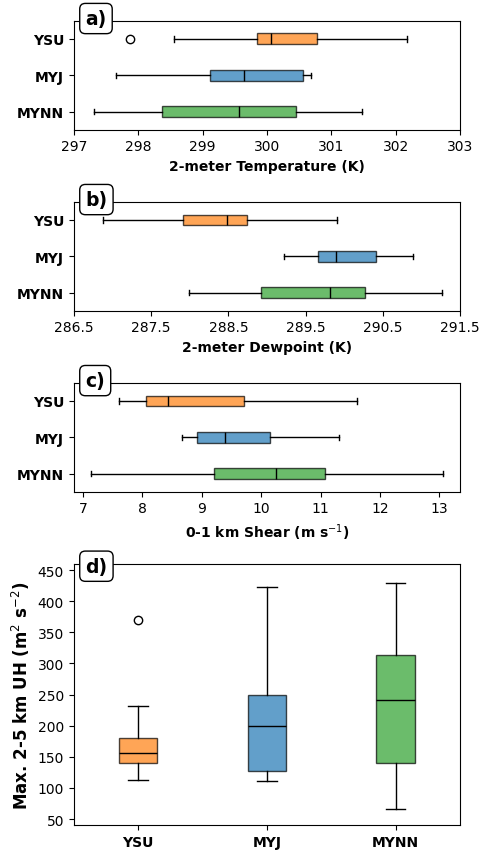

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(5,8.7), gridspec_kw={'height_ratios': [1.25, 1.25, 1.25, 3]})

for i in range(len(ax)):
    
    if i < 3:
        bplot = ax[i].boxplot([means[i,ysu_idx], means[i,myj_idx], means[i,mynn_idx]],
                               patch_artist=True, medianprops=dict(c='k'), vert=False)
        ax[i].set_yticks([])
        #ax[i].set_title(varlist[i], weight='bold')
            
        t_statistic, pval_ysu = stats.ttest_1samp(means[i,ysu_idx], popmean=np.mean(means[i]))
        t_statistic, pval_myj = stats.ttest_1samp(means[i,myj_idx], popmean=np.mean(means[i]))
        t_statistic, pval_mynn = stats.ttest_1samp(means[i,mynn_idx], popmean=np.mean(means[i]))    
       
        #ax[i].set_ylabel(varlist[i], size=14, weight='bold') 
        ax[i].set_yticks([1,2,3])
        ax[i].set_yticklabels(['YSU','MYJ','MYNN'], weight='bold')
        ax[i].invert_yaxis()
        
    if i == 3:
        bplot = ax[i].boxplot([uhresp_gr[ysu_idx],uhresp_gr[myj_idx],uhresp_gr[mynn_idx]],
                               patch_artist=True, medianprops=dict(c='k'))
        ax[i].set_ylabel(f'Max. 2-5 km UH ({wofunits.labels[respvar_filestr]})', size=12, weight='bold')    
        ax[i].set_xticks([])
    
        t_statistic, pval_ysu = stats.ttest_1samp(uhresp_gr[ysu_idx], popmean=np.mean(uhresp_gr))
        t_statistic, pval_myj = stats.ttest_1samp(uhresp_gr[myj_idx], popmean=np.mean(uhresp_gr))
        t_statistic, pval_mynn = stats.ttest_1samp(uhresp_gr[mynn_idx], popmean=np.mean(uhresp_gr))
        
        
    # fill with colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    if i == 0:
        #xlims = (296.5, 303.5)
        #ax[i].set_xlim(xlims[0],xlims[1])
        ax[i].set_xticks(np.arange(297,303+0.1,1)) 
        ax[i].set_xlabel(f'2-meter Temperature ({wofunits.labels[varlist[i]]})', weight='bold')
    if i == 1:
        xlims = (281.45, 283.65)
        #ax[i].set_xlim(xlims[0],xlims[1])
        ax[i].set_xticks(np.arange(286.5,291.5+0.1,1))
        ax[i].set_xlabel(f'2-meter Dewpoint ({wofunits.labels[varlist[i]]})', weight='bold')
    elif i == 2:
        xlims = (8.75,11.25)
        #ax[i].set_xlim(xlims[0],xlims[1])
        ax[i].set_xticks(np.arange(7,13+0.1,1))
        ax[i].set_xlabel(f'0-1 km Shear ({wofunits.labels[varlist[i]]})', weight='bold')
    elif i == 0 or i == 2:
        xlims = ax[i].get_xlim()
    elif i == 3:
        ax[i].set_xticks([1,2,3])
        ax[i].set_xticklabels(['YSU','MYJ','MYNN'], weight='bold')
        ax[i].set_ylim(40,460)
    
    ax[i].text(0.03, 0.97, axlabels[i], color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
        size=13.5, weight='bold')
    
    #if pval_ysu <= 0.05: 
    #    ax[i].scatter(xlims[1]-(xlims[1]-xlims[0])*0.025, 1.1, marker='s', c='k', s=25)
    #if pval_myj <= 0.05:
    #    ax[i].scatter(xlims[1]-(xlims[1]-xlims[0])*0.025, 2.1, marker='s', c='k', s=25)
    #if pval_mynn <= 0.05:
    #    ax[i].scatter(xlims[1]-(xlims[1]-xlims[0])*0.025, 3.1, marker='s', c='k', s=25)

fig.tight_layout()

if save == True:
    plt.savefig(fname=f'{outplot_path}/multiphysics_boxplots.png', dpi=300, bbox_inches='tight', facecolor='w')